# Install libraries

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import libraries

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
import time

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col,when
import pyspark.sql.types as T

import json
import random

#spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

# Download Dataset from Kaggle

In [3]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker

od.download(
    "https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe")

Skipping, found downloaded files in "./515k-hotel-reviews-data-in-europe" (use force=True to force download)


In [4]:
# reading the csv file
file = ('515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv')
rawData = pd.read_csv(file)

# loading dataset to spark, this will take a minute
df = spark.createDataFrame(rawData)

# Drop Null values

In [5]:
# turn empty entries to None
df = df.select([when(col(c)=='', None).otherwise(col(c)).alias(c) for c in df.columns])

# drop Null/None values
df.na.drop()

DataFrame[Hotel_Address: string, Additional_Number_of_Scoring: bigint, Review_Date: string, Average_Score: double, Hotel_Name: string, Reviewer_Nationality: string, Negative_Review: string, Review_Total_Negative_Word_Counts: bigint, Total_Number_of_Reviews: bigint, Positive_Review: string, Review_Total_Positive_Word_Counts: bigint, Total_Number_of_Reviews_Reviewer_Has_Given: bigint, Reviewer_Score: double, Tags: string, days_since_review: string, lat: double, lng: double]

In [6]:
hotel_df = df.toDF("Hotel_Address","Additional_Number_of_Scoring","Review_Date","Average_Score", \
                   "Hotel_Name","Reviewer_Nationality","Negative_Review", "Review_Total_Negative_Word_Counts", \
                   "Total_Number_of_Reviews", "Positive_Review", "Review_Total_Positive_Word_Counts", \
                   "Total_Number_of_Reviews_Reviewer_Has_Given", "Reviewer_Score", "Tags", "days_since_review", \
                   "lat", "lng").cache()
hotel_df.createOrReplaceTempView("hotel_df")

In [7]:
hotel_df.show()

+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------------------+--------------+--------------------+-----------------+----------+---------+
|       Hotel_Address|Additional_Number_of_Scoring|Review_Date|Average_Score| Hotel_Name|Reviewer_Nationality|     Negative_Review|Review_Total_Negative_Word_Counts|Total_Number_of_Reviews|     Positive_Review|Review_Total_Positive_Word_Counts|Total_Number_of_Reviews_Reviewer_Has_Given|Reviewer_Score|                Tags|days_since_review|       lat|      lng|
+--------------------+----------------------------+-----------+-------------+-----------+--------------------+--------------------+---------------------------------+-----------------------+--------------------+---------------------------------+------------------------------

#Festure 1: Top 5 tags for each hotel

In [ ]:
# extract hotel name and tags
Hotel_name_tag_data = hotel_df.select('Hotel_Name', 'Tags').toDF('Hotel_Name', 'Tags').cache()
# trim the reviewer hotel name and tags columns
Hotel_name_tag_data = Hotel_name_tag_data.withColumn('Hotel_Name', F.trim(Hotel_name_tag_data.Hotel_Name))
Hotel_name_tag_data = Hotel_name_tag_data.withColumn('Tags', F.trim(Hotel_name_tag_data.Tags))
Hotel_name_tag_data.createOrReplaceTempView("Hotel_name_tag_data")
Hotel_name_tag_data.show()
# get all possible hotels
hotel_name_all = Hotel_name_tag_data.rdd.map(lambda x: x[0]).distinct().cache()

+-----------+--------------------+
| Hotel_Name|                Tags|
+-----------+--------------------+
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Business trip ...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Business trip ...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Leisure trip '...|
|Hotel Arena|[' Business trip ...|
|Hotel Arena|[' Leisure trip '...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
# function to tokenize hotel tag
def tokenizarion(tag):
    tag = tag.replace("'", "")
    tag = tag.replace("[", "")
    tag = tag.replace("]", "")
    
    for item in tag:
      tags_out = [n.strip() for n in tag.split(',')]
    return tags_out

# function to extract top five tags and teir counts
def get_top_five_tage(hotel):
    hotel_name_tags = Hotel_name_tag_data.filter("Hotel_Name == '{}'".format(hotel))
    hotel_tags = hotel_name_tags.rdd.map(lambda x: tokenizarion(x[1]))
    hotel_tag_count = hotel_tags.flatMap(lambda x: [(x[i], 1) for i in range (len(x))]) \
                                .reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], ascending=False)

    return dict(hotel_tag_count.take(5))

# plot function
def visualize_top_five_tag(tag_dic, hotel_name):
    # set plot size
    plt.figure(figsize=(12, 5))
    sns.set_style('darkgrid')
    # get tags and counts
    tags = list(tag_dic.keys())
    counts = list(tag_dic.values())
    plt.bar(tags, counts, color ='maroon', width = 0.4)
    plt.xlabel("Tags for hotel")
    plt.ylabel("Tags counts")
    plt.title("Top 5 tags for hotel: {}".format(hotel_name))
    plt.show()


In [ ]:
'''
Fucntion: Get the top five tags associate with a specific hotel
-- input: hotel name
-- return: garph represent top five tags and their counts
'''
def plot_top_five_tgas():
    while True:
        hotel_name = input("Enter a hotel name to start, exit to leave: ")
        if hotel_name == "exit":
            return
        if hotel_name in hotel_name_all.collect():
            visualize_top_five_tag(get_top_five_tage(hotel_name), hotel_name)
        else:
            print("Please enter a valid hotel name")

plot_top_five_tgas()

Enter a hotel name to start, exit to leave: exit


# Feature 2: Top 10 most popular hotels by nation

In [ ]:
# extract smaller dataframe used to construct interface
Hotel_nationality_score_data = hotel_df.select('Hotel_Name', 'Reviewer_Nationality', 'Reviewer_Score').toDF('Hotel_Name', 'Reviewer_Nationality', 'Reviewer_Score').cache()
# Trim the reviewer nationality column
Hotel_nationality_score_data = Hotel_nationality_score_data.withColumn("Reviewer_Nationality", F.trim(Hotel_nationality_score_data.Reviewer_Nationality))
# Trim the hotel name column
Hotel_nationality_score_data = Hotel_nationality_score_data.withColumn("Hotel_Name", F.trim(Hotel_nationality_score_data.Hotel_Name))

Hotel_nationality_score_data.createOrReplaceTempView("Hotel_nationality_score_data")

Hotel_nationality_score_data.show()

+-----------+--------------------+--------------+
| Hotel_Name|Reviewer_Nationality|Reviewer_Score|
+-----------+--------------------+--------------+
|Hotel Arena|              Russia|           2.9|
|Hotel Arena|             Ireland|           7.5|
|Hotel Arena|           Australia|           7.1|
|Hotel Arena|      United Kingdom|           3.8|
|Hotel Arena|         New Zealand|           6.7|
|Hotel Arena|              Poland|           6.7|
|Hotel Arena|      United Kingdom|           4.6|
|Hotel Arena|      United Kingdom|          10.0|
|Hotel Arena|             Belgium|           6.5|
|Hotel Arena|              Norway|           7.9|
|Hotel Arena|      United Kingdom|          10.0|
|Hotel Arena|              France|           5.8|
|Hotel Arena|      United Kingdom|           4.6|
|Hotel Arena|               Italy|           9.2|
|Hotel Arena|              Canada|           8.8|
|Hotel Arena|               Italy|          10.0|
|Hotel Arena|      United Kingdom|           6.3|


In [ ]:
# get all valid nations from the dataset 
all_nations = Hotel_nationality_score_data.rdd.map(lambda x: x[1]).distinct()
all_nations.cache()

# all valid nation names
all_nations.collect()

['Ireland',
 'Australia',
 'Poland',
 'Belgium',
 'Norway',
 'France',
 'Netherlands',
 'United States of America',
 'Hungary',
 'Switzerland',
 'India',
 'Denmark',
 'South Africa',
 'Finland',
 'Portugal',
 'China',
 'Ukraine',
 'Gibraltar',
 'Argentina',
 'Isle of Man',
 'Saudi Arabia',
 'Slovenia',
 'Austria',
 'Brazil',
 'Iceland',
 'Iran',
 'United States Minor Outlying Islands',
 'Lebanon',
 'Nigeria',
 'Greece',
 'Thailand',
 'Guernsey',
 'Latvia',
 'Slovakia',
 'South Korea',
 'Kuwait',
 'Bahrain',
 'Cyprus',
 'Albania',
 'Estonia',
 'Puerto Rico',
 'Honduras',
 'Philippines',
 'Montenegro',
 'Uruguay',
 'Pakistan',
 'Kosovo',
 '',
 'Botswana',
 'Tanzania',
 'Trinidad and Tobago',
 'Palestinian Territory',
 'Peru',
 'Mexico',
 'Kenya',
 'Macedonia',
 'Bermuda',
 'Costa Rica',
 'Maldives',
 'Barbados',
 'Libya',
 'Fiji',
 'Angola',
 'Kazakhstan',
 'Vietnam',
 'Iraq',
 'Monaco',
 'Togo',
 'Guatemala',
 'Ghana',
 'Zambia',
 'Mauritius',
 'Venezuela',
 'St Maarten',
 'Algeria',
 '

In [ ]:
# function to plot the bargraph
def plot_top10_chart(q):
  # Given valid nation name q, create new dataframe that contains hotel names and reviewer scores for reviewers of nationnality q
  nation_scores = Hotel_nationality_score_data.filter("Reviewer_Nationality == '{}'".format(q)).select('Hotel_Name', 'Reviewer_Score').toDF('Hotel_Name', 'Reviewer_Score').cache()
  nation_scores.createOrReplaceTempView("nation_scores")

  # sum up the scores for each hotel name, take the 10 highest scoring hotel names and their scores
  total_scores = spark.sql('select Hotel_Name, sum(Reviewer_Score) as total_score from nation_scores group by Hotel_Name order by total_score desc limit 10').toDF('Hotel_Name', 'total_score').cache()
  total_scores.createOrReplaceTempView("total_scores")

  # turn hotel_names and hotel_scores into string and num valued rdds
  hotel_names = total_scores.rdd.map(lambda x: x[0])
  hotel_scores = total_scores.rdd.map(lambda x: x[1])

  # create dictionary with hotel_names hotel_scores pairs and sort in ascending order of hotel_scores
  hotel_dictionary = dict(zip(hotel_names.collect(), hotel_scores.collect()))
  hotel_dictionary = {k: v for k, v in sorted(hotel_dictionary.items(), key=lambda item: item[1])}

  # set plot size
  plt.figure(figsize=(7, 5))

  # set plot background
  sns.set_style('darkgrid')

  # Create horizontal bars
  y_pos = np.arange(10)
  plt.barh(y_pos, hotel_dictionary.values(), color=(0.2, 0.4, 0.6, 0.6), height=0.5)
  
  # Create names on the y-axis, x-axis, and title
  plt.yticks(y_pos, hotel_dictionary.keys())
  plt.xlabel('Total Score \n', fontsize=14, labelpad = 15)
  plt.title("\n Top 10 Most Popular Hotels for Reviewers from {}".format(q), fontsize=18, pad=25)
  # Show graphic
  plt.show()

Input nation name to get the top 10 most popular hotels: Korea
Please enter a valid nation name
Input nation name to get the top 10 most popular hotels: South Korea


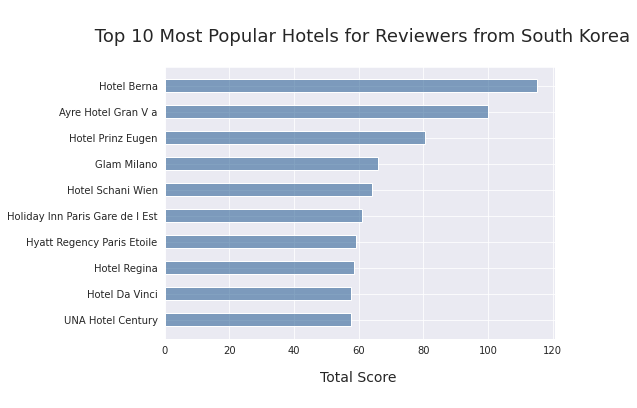

Input nation name to get the top 10 most popular hotels: 


In [ ]:
def Top_10_hotels_Generator():
  while True:
      # prompt message
      q = input("Input nation name to get the top 10 most popular hotels: ")
      q = q.strip()

      # boolean value of whether q is a valid nation name
      valid_nation_bool = q in all_nations.collect()

      if len(q) == 0:
          return

      if valid_nation_bool == True:
          plot_top10_chart(q)
      else:
          print("Please enter a valid nation name")

Top_10_hotels_Generator()

# Feature 3: Tourist Review Score Over Time

In [ ]:
# extract smaller dataframe used to construct interface
Overtime_review_score = hotel_df.select('Hotel_Name', 'Review_Date', 'Reviewer_Score').toDF('Hotel_Name', 'Review_Date', 'Reviewer_Score').cache()
# Trim the Review_Date column and change the date format to YYYY-MM-DD
Overtime_review_score = Overtime_review_score.withColumn("Review_Date", F.trim(Overtime_review_score.Review_Date))
transform_date = F.udf(lambda date : datetime.strptime(date, '%m/%d/%Y').date().strftime("%Y-%m-%d"))
Overtime_review_score = Overtime_review_score.withColumn("Review_Date", transform_date(Overtime_review_score.Review_Date))

# Trim the hotel name column
Overtime_review_score = Overtime_review_score.withColumn("Hotel_Name", F.trim(Overtime_review_score.Hotel_Name))
Overtime_review_score.createOrReplaceTempView("Overtime_review_score")

Overtime_review_score.show()


+-----------+-----------+--------------+
| Hotel_Name|Review_Date|Reviewer_Score|
+-----------+-----------+--------------+
|Hotel Arena| 2017-08-03|           2.9|
|Hotel Arena| 2017-08-03|           7.5|
|Hotel Arena| 2017-07-31|           7.1|
|Hotel Arena| 2017-07-31|           3.8|
|Hotel Arena| 2017-07-24|           6.7|
|Hotel Arena| 2017-07-24|           6.7|
|Hotel Arena| 2017-07-17|           4.6|
|Hotel Arena| 2017-07-17|          10.0|
|Hotel Arena| 2017-07-09|           6.5|
|Hotel Arena| 2017-07-08|           7.9|
|Hotel Arena| 2017-07-07|          10.0|
|Hotel Arena| 2017-07-06|           5.8|
|Hotel Arena| 2017-07-06|           4.6|
|Hotel Arena| 2017-07-04|           9.2|
|Hotel Arena| 2017-07-04|           8.8|
|Hotel Arena| 2017-07-03|          10.0|
|Hotel Arena| 2017-07-03|           6.3|
|Hotel Arena| 2017-06-30|           7.5|
|Hotel Arena| 2017-06-29|           7.1|
|Hotel Arena| 2017-06-20|           7.5|
+-----------+-----------+--------------+
only showing top

In [ ]:
# get all valid hotels from the dataset 
all_hotels = Overtime_review_score.rdd.map(lambda x: x[0]).distinct()
all_hotels.cache()

# all valid hotel names
all_hotels.collect()

['K K Hotel George',
 'Apex Temple Court Hotel',
 'The Park Grand London Paddington',
 'The Principal London',
 'Splendid Etoile',
 'Novotel Suites Paris Nord 18 me',
 'Milestone Hotel Kensington',
 'Crowne Plaza London Kings Cross',
 'Select Hotel',
 'Gardette Park Hotel',
 'Hotel Panache',
 'Hotel Scribe Paris Opera by Sofitel',
 'Novotel London West',
 'Haymarket Hotel',
 'Intercontinental London The O2',
 'H tel Juliana Paris',
 'Knightsbridge Hotel',
 'The Cranley Hotel',
 'Hotel Le 10 BIS',
 'Grange St Paul s Hotel',
 'The Ampersand Hotel',
 'Novotel London Tower Bridge',
 'Atala Champs Elys es',
 'Windsor Opera',
 'Les Plumes Hotel',
 'Hotel des Tuileries Relais du Silence',
 'W London Leicester Square',
 'The Victoria',
 'Pullman London St Pancras',
 'The Grosvenor',
 'Thistle Kensington Gardens',
 'Hilton Paris Opera',
 'Shepherd s Bush Boutique Hotel',
 'My Bloomsbury',
 'Holiday Inn Paris Gare de Lyon Bastille',
 'H tel Chaplain Paris Rive Gauche',
 '11 Cadogan Gardens',
 'H

In [ ]:
def plot_scores_overtime_chart(q):
  # Given valid hotel name q, create new dataframe that contains Review_Date and Reviewer_Score for hotel q
  review_scores = Overtime_review_score.filter("Hotel_Name == '{}'".format(q)).select('Review_Date', 'Reviewer_Score').toDF('Review_Date', 'Reviewer_Score').cache()
  review_scores.createOrReplaceTempView("review_scores")

  # sort in ascending order of review date
  score_overtime = spark.sql('select Review_Date, Reviewer_Score from review_scores order by Review_Date').toDF('Review_Date', 'Reviewer_Score').cache()
  score_overtime.createOrReplaceTempView("score_overtime")

  # turn hotel_names and hotel_scores into string valued rdds
  time = score_overtime.rdd.map(lambda x: x[0])
  score = score_overtime.rdd.map(lambda x: x[1])

  # set plot size
  plt.figure(figsize=(13, 4))

  # set plot background
  sns.set_style('darkgrid')

  # Create scatter plot
  plt.scatter(time.collect(), score.collect(), color=(0.2, 0.4, 0.6, 0.6))

  # Create names on the y-axis, x-axis, and title
  plt.ylabel('Score', fontsize=14)
  plt.ylim(0,10.5)
  plt.xlabel('Time \n', fontsize=14, labelpad = 15)
  plt.title("\n Tourist Review Score Over Time for {}".format(q), fontsize=18, pad=25)

  # set the date ticks on x-axis
  plt.xticks(rotation=45)
  ax=plt.gca()
  ax.xaxis.set_major_locator(ticker.LinearLocator(15))

  # Show graphic
  plt.show()


Input hotel name: The Marylebone Hotel


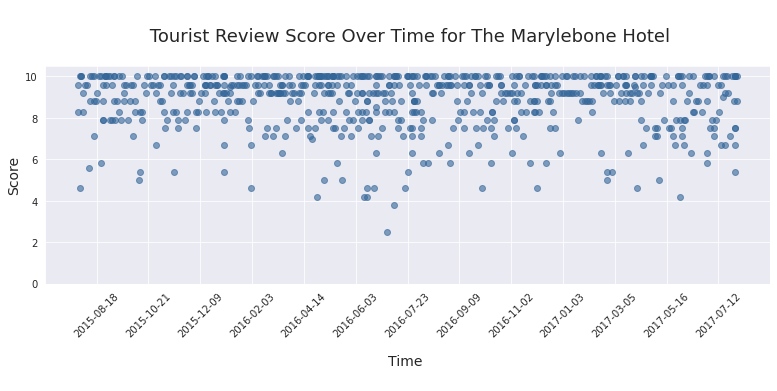

Input hotel name: Suites H tel Helzear Champs Elys es


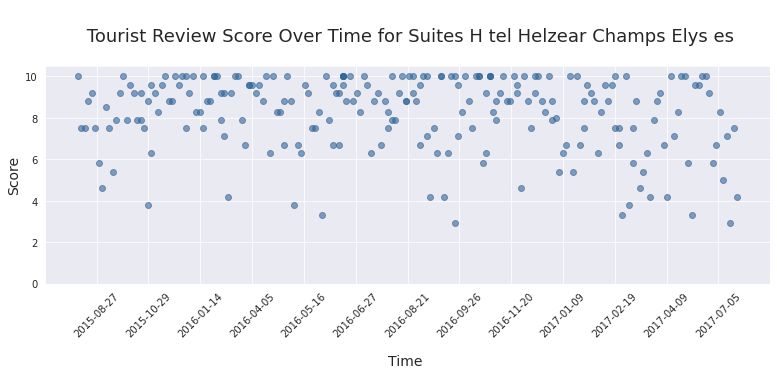

Input hotel name: 


In [ ]:
def Overtime_Score_Generator():
  while True:
      # prompt message
      q = input("Input hotel name: ")
      q = q.strip()

      if len(q) == 0:
          return

      # boolean value of whether q is a valid hotel name
      if q in all_hotels.collect():
          plot_scores_overtime_chart(q)
      else:
          print("Please enter a valid hotel name")

Overtime_Score_Generator()

# Feature 4: Sentiment Analysis

In [8]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import expr
from pyspark.sql.functions import col,lit

**Cleaning Dataset**

The dataset is too large to form a model of a sentiment test, so I decided to get a sample of 30k data to train and test my model.

In [9]:
# get rid of "no negative" and "no positive" in reviews
hotel_df = hotel_df.filter("Negative_Review != 'No Negative'").filter("Positive_Review != 'No Positive'")
sample = hotel_df.orderBy(F.rand()).limit(30000)

# extract reviews and merge them into one column
# label negative as 0 and positive as 1
Hotel_Negative_Reviews = sample.select("Negative_Review").toDF('Negative_Review').withColumn("Sentiment_Label",lit(0)).cache()
Hotel_Negative_Reviews = Hotel_Negative_Reviews.withColumn("union",lit(1))
Hotel_Positive_Reviews = sample.select("Positive_Review").toDF('Positive_Review').withColumn("Sentiment_Label",lit(1)).cache()
Hotel_Positive_Reviews = Hotel_Positive_Reviews.withColumn("union",lit(1))
Hotel_Reviews = Hotel_Negative_Reviews.union(Hotel_Positive_Reviews).where("union = 1").withColumnRenamed("Negative_Review", "Reviews").cache()
Hotel_Reviews = Hotel_Reviews.drop(Hotel_Reviews["union"])

Hotel_Reviews.createOrReplaceTempView("Hotel_Reviews")
Hotel_Reviews.show(2)

+--------------------+---------------+
|             Reviews|Sentiment_Label|
+--------------------+---------------+
|             Nothing|              0|
| Room was ridicul...|              0|
+--------------------+---------------+
only showing top 2 rows



In [10]:
# tokenize reviews
tokenizer = Tokenizer(inputCol="Reviews", outputCol="Review_Tokens")
Tokenized_Hotel_Reviews = tokenizer.transform(Hotel_Reviews).cache()
# get rid of empty tokens
Tokenized_Hotel_Reviews = Tokenized_Hotel_Reviews.withColumn("Review_Tokens", expr("filter(Review_Tokens, elem -> elem != '')"))
#Tokenized_Hotel_Reviews.show(3)

# remove stop words
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
        'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's",
        'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'this', 'that', "that'll", 'these',
        'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 
        'a', 'an', 'the', 'do', 'does', 'did', 'doing', 't', 'f']
              
              
stop_words_remover = StopWordsRemover(inputCol='Review_Tokens', outputCol='Cleaned_Review_Tokens', stopWords=stop_words)
Cleaned_Hotel_Reviews = stop_words_remover.transform(Tokenized_Hotel_Reviews)
# ensure the token is not empty
Cleaned_Hotel_Reviews = Cleaned_Hotel_Reviews.filter(f.size('Cleaned_Review_Tokens') > 0)
#Cleaned_Hotel_Reviews.show(5)

In [11]:
# converting list of strings of a review to list of integers based on frequency of each word
cv = CountVectorizer(inputCol="Cleaned_Review_Tokens", outputCol="features")
cv_model = cv.fit(Cleaned_Hotel_Reviews)
CV_df = cv_model.transform(Cleaned_Hotel_Reviews)

CV_df.show(5)

+--------------------+---------------+--------------------+---------------------+--------------------+
|             Reviews|Sentiment_Label|       Review_Tokens|Cleaned_Review_Tokens|            features|
+--------------------+---------------+--------------------+---------------------+--------------------+
|             Nothing|              0|           [nothing]|            [nothing]|  (20738,[33],[1.0])|
| Room was ridicul...|              0|[room, was, ridic...| [room, ridiculous...|(20738,[0,1,2,20,...|
| I had a hotel ro...|              0|[i, had, a, hotel...| [hotel, room, wit...|(20738,[2,3,9,14,...|
| The initial room...|              0|[the, initial, ro...| [initial, room, a...|(20738,[1,2,4,6,7...|
|             Nothing|              0|           [nothing]|            [nothing]|  (20738,[33],[1.0])|
+--------------------+---------------+--------------------+---------------------+--------------------+
only showing top 5 rows



**Sentiment Analysis**

In [12]:
# split training set and testing set
(training_set, testing_set) = CV_df.randomSplit([0.9, 0.1], seed = 631)
#testing_set.count()

In [13]:
# train Logistic Regression model 
lr_model = LogisticRegression(featuresCol='features', labelCol='Sentiment_Label')
LR_Model = lr_model.fit(training_set)

# predict using the testing set
Predict_Test = LR_Model.transform(testing_set)
Predict_Table = Predict_Test.select('Reviews', "Cleaned_Review_Tokens", 'Sentiment_Label', 'prediction')
Predict_Table.show(10)

+--------------------+---------------------+---------------+----------+
|             Reviews|Cleaned_Review_Tokens|Sentiment_Label|prediction|
+--------------------+---------------------+---------------+----------+
| 1 Internet conne...| [1, internet, con...|              0|       0.0|
| 1 Its 3 stars ho...| [1, 3, stars, hot...|              0|       0.0|
| 1 Just one power...| [1, just, one, po...|              0|       0.0|
| 1 Paid for break...| [1, paid, for, br...|              0|       0.0|
| 1 Poor Wifi 2 Pr...| [1, poor, wifi, 2...|              0|       0.0|
| 1 Poor room allo...| [1, poor, room, a...|              0|       0.0|
| 1 The A C was no...| [1, c, not, worki...|              0|       0.0|
| 1 The room smelt...| [1, room, smelt, ...|              0|       0.0|
| 1 We arrived aft...| [1, arrived, afte...|              0|       0.0|
| 1 We stayed thre...| [1, stayed, three...|              0|       0.0|
+--------------------+---------------------+---------------+----

**Evaluation**

In [14]:
trainingSummary = LR_Model.summary
# present the training performance
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

# obtain the receiver-operating characteristic as areaUnderROC
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

Accuracy: 0.966192697918981
FPR: 0.03380422664067871
TPR: 0.966192697918981
F-measure: 0.9661926732121355
Precision: 0.9661971024277471
Recall: 0.966192697918981
areaUnderROC: 0.9950911416985726


/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


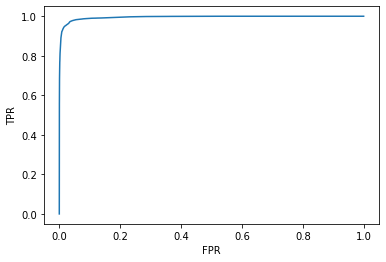

In [15]:
# draw a ROC curve
plt.plot(trainingSummary.roc.select('FPR').collect(),
     trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Word Cloud

## import and download libraries

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

## world cloud construction

In [ ]:
# get rid of "no negative" and "no positive" in reviews
hotel_df = hotel_df.filter("Negative_Review != 'No Negative'").filter("Positive_Review != 'No Positive'")
hotel_review = hotel_df.select("Hotel_Name", "Negative_Review", "Positive_Review").toDF("Hotel_Name", "Negative_Review", "Positive_Review").cache()
# trim the reviewer hotel name and tags columns
hotel_review_data = hotel_review.withColumn('Hotel_Name', F.trim(hotel_review.Hotel_Name))
hotel_review_data = hotel_review_data.withColumn('Negative_Review', F.trim(hotel_review_data.Negative_Review))
hotel_review_data = hotel_review_data.withColumn('Positive_Review', F.trim(hotel_review_data.Positive_Review))
hotel_review_data.createOrReplaceTempView("hotel_review_data")
hotel_review_data.show()
# get all possible hotels
hotel_name_all = hotel_review_data.rdd.map(lambda x: x[0]).distinct().cache()

In [ ]:
def review_tokenization(review):
    review = review.lower()
    review = review.replace("'", "")
    review = review.replace("[", "")
    review = review.replace("]", "")
    # remove punctuation
    review = "".join(x for x in review if x not in ("?", ".", ";", ":",  "!",'"'))
    # remove common words
    review = word_tokenize(review)
    stopwords_update = set(stopwords.words('english'))
    stopwords_update.update(["rooms","would","hotel","us"])
    review = [x for x in review if x not in stopwords_update]
    return review


# function to extract postive review and negative review for a given hotel
def get_negative_review(hotel):
    hotel_name_review = hotel_review_data.filter("Hotel_Name == '{}'".format(hotel))
    hotel_review = hotel_name_review.rdd.map(lambda x: (x[0], review_tokenization(x[1]))) \
                   .reduceByKey(lambda x, y: x+y).map(lambda x: x[1])

    return hotel_review.collect()

def get_positive_review(hotel):
    hotel_name_review = hotel_review_data.filter("Hotel_Name == '{}'".format(hotel))
    hotel_review = hotel_name_review.rdd.map(lambda x: (x[0], review_tokenization(x[2]))) \
                   .reduceByKey(lambda x, y: x+y).map(lambda x: x[1])

    return hotel_review.collect()

In [ ]:
import numpy as np
from collections import Counter
def helper_plot(review_list, max_word):
    # flatten list
    flatten_review = list(np.concatenate(review_list).flat)
    review_word_count_dict = dict(Counter(flatten_review))
    review_popular_words = sorted(review_word_count_dict, key = review_word_count_dict.get, reverse = True)
    print(review_popular_words)
    review_wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=max_word,
                          width=1000,height=1000,
                         ).generate(str(review_popular_words))
    return review_wordcloud


# function to plot the cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.show()

In [ ]:
output = get_negative_review("Hotel Arena")
plot_cloud(helper_plot(output,100))



## user interface

In [ ]:
'''
Fucntion: Get the review world cloud a specific hotel
-- input: hotel name
-- return: world cloud with most 100 frequent words for positive/negative review
'''
def plot_review_wordCloud():
    while True:
        hotel_name = input("Enter a hotel name to start, exit to leave: ")
        if hotel_name == "exit":
            return
        if hotel_name in hotel_name_all.collect():
            neg_output = get_negative_review(hotel_name)
            pos_output = get_positive_review(hotel_name)
            plot_cloud(helper_plot(neg_output,100))
            plot_cloud(helper_plot(pos_output,100))
        else:
            print("Please enter a valid hotel name")

plot_review_wordCloud()

References:
1. https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/